**Задание 1: составить словари для классификации по тональности.**

Данные для задания — отзывы на банки, собранные с нескольких сайтов рунета. Отзывы могут быть как положительными — оценка 5, так и отрицательными — оценка 1.

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
Обучите по коллекции предложений word2vec

2. Приведите несколько удачных и неудачных примеров решения стандартных
текстов для word2vec:

- тест на определение ближайших слов;
- тест на аналогии (мужчина — король : женщина — королева);
- тест на определение лишнего слова.

3. Постройте несколько визуализаций:

- TSNE для топ-100 или топ-500 слов и найдите осмысленные кластеры слов;

- задайте координаты для нового пространства следующим образом: одна ось описывает отношение «плохо — хорошо», вторая — «медленно — быстро», и найдите координаты названий банков в этих координатах.

**Задание 2: распространить метку.**

1. Определите 5–8 позитивных слов (например, быстрый, удобный) и 5–8 негативных слов (например, очередь, медленно). Эти слова будут основной будущего оценочного словаря;

2. Пусть позитивному классу соответствует метка 1, негативному — -1;

3. Пометьте выбранные слова в лексическом графе соответствующими метками;

4. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе;

5. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 — это и есть искомые оценочные слова.

**Результат:**

Jupyter notebook с предобработанным текстом, аналитикой и выбранными топ-5–8 негативными и позитивными словами

**Задание 1**

Импорт библиотек, загрузка данных.

In [ ]:
import json

import bz2
import re
from tqdm import tqdm
from scipy import sparse

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:10, 1545.51it/s]


In [ ]:
responses[:2]

[{'city': 'г. Москва',
  'rating_not_checked': False,
  'title': 'Жалоба',
  'num_comments': 0,
  'bank_license': 'лицензия № 2562',
  'author': 'uhnov1',
  'bank_name': 'Бинбанк',
  'datetime': '2015-06-08 12:50:54',
  'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом 

Выполним предобработку текстов отзывов.

In [ ]:
def cleaning(response):

  resp_ = re.sub(r'http\S+', '', response) # удаление ссылок
  resp_ = re.sub('-', ' ', resp_) # замена дефисов на пробелы
  resp_ = resp_.lower() # приведение к нижнему регистру
  resp_ = re.sub('\s+', ' ', resp_) # удаление лишних пробельных символов
  #resp_ = re.sub('[^а-яёА-Я-Ё\s]', '', resp_) # удаление всего, что не является токенами из кириллических букв, в т.ч. знаков пунктуации

  return resp_

In [ ]:
clean_responses = {}

for el in tqdm(responses):
    clean_resp = cleaning(el['text'])
    clean_responses[clean_resp] = el['rating_grade']

100%|██████████| 153499/153499 [00:25<00:00, 6095.96it/s]


In [ ]:
len(responses), len(clean_responses)

(153499, 153412)

In [ ]:
for k, v in list(clean_responses.items())[:3]:
  print(k, '\n', v)


добрый день! я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким либо другим лицом, письменно оформившим отношения с банком по поводу урегулирования чьей либо задолженности. начиная с марта 2015 года начали приходить бесконечные письма из ооо "примо коллект"на мой адрес: город москва, уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. со всей ответственностью хочу вас заверить, что вышеуказанный гражданин, которого вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно, и почему по вашей милости я должна переживать и бояться за себе и свое имущество. письма доставляют мне серьезные 

**1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
Обучите по коллекции предложений word2vec**

Разбивку отзывов на предложения выполним с помощью библиотеки nltk.

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
text_sentences = []

for resp in tqdm(clean_responses):
  sentences = nltk.sent_tokenize(resp, language = 'russian')

  for one_sent in sentences:
    one_sent = re.sub(f'[{punctuation}]', '', one_sent)
    text_sentences.append(one_sent)

100%|██████████| 153412/153412 [01:58<00:00, 1291.31it/s]


In [ ]:
# Первые два предложения полученного списка:
text_sentences[:2]

['добрый день',
 'я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь каким либо другим лицом письменно оформившим отношения с банком по поводу урегулирования чьей либо задолженности']

Для лемматизации воспользуемся инструментом библиотеки pymorphy2.

In [ ]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 51.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=fd8ebfc6451ee56a9dbfc6775a2cf43a3c935edc09d0f1eaea244d7d66b118af
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

Список стоп-слов русского языка загрузим из библиотеки nltk.

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stopwords_ru = stopwords.words('russian')

In [ ]:
stopwords_ru[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [ ]:
# Функция для разбивки предложеий на токены, лемматизации и удаления стоп-слов:

def lemmatize(text):
  tokens = word_tokenize(text)
  for i, token in enumerate(tokens):
    tokens[i] = pymorphy2_analyzer.parse(token)[0].normal_form
  return [word for word in tokens if word not in stopwords_ru] # стоп-слова не добавляем

In [ ]:
%%time
tok_lem_sentences = [lemmatize(el) for el in text_sentences]

  3%|▎         | 59968/2383198 [08:51<5:43:00, 112.89it/s]


CPU times: user 2h 42min 30s, sys: 22.3 s, total: 2h 42min 53s
Wall time: 2h 43min 47s


In [ ]:
tok_lem_sentences[:2]

[['добрый', 'день'],
 ['являться',
  'клиент',
  'банк',
  'поручитель',
  'кредитный',
  'договор',
  'также',
  'являться',
  'либо',
  'лицо',
  'письменно',
  'оформить',
  'отношение',
  'банк',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность']]

Обучение модели w2v на полученной коллекции предложений tok_lem_sentences:

In [ ]:
from gensim.models.word2vec import Word2Vec

In [ ]:
%%time
model_responses = Word2Vec(tok_lem_sentences, workers=4, vector_size=300, min_count=3, window=5)

CPU times: user 9min 7s, sys: 2.65 s, total: 9min 10s
Wall time: 5min 26s


Т.к. подготовка модели заняла несколько часов, сохраним ее в файл для упрощения доступа в будущем:

In [ ]:
model_responses.wv.save_word2vec_format('responses_w2v.txt', binary=False)

**2. Приведите несколько удачных и неудачных примеров решения стандартных
тестов для word2vec:**

**- тест на определение ближайших слов;**

In [ ]:
words_sim = ['вклад', 'очередь', 'отделение']

In [ ]:
for word in words_sim:
  print(word, model_responses.wv.most_similar(word, topn=5))

вклад [('депозит', 0.9170926809310913), ('твклад', 0.5955804586410522), ('смартвклад', 0.5810350179672241), ('депозитный', 0.5810306072235107), ('омс', 0.5585422515869141)]
очередь [('толпа', 0.6453055143356323), ('очередище', 0.5194854736328125), ('очередь…', 0.512546956539154), ('народ', 0.5053631663322449), ('окошко', 0.4934684634208679)]
отделение [('допофис', 0.8427976369857788), ('офис', 0.8390111923217773), ('филиал', 0.7794716954231262), ('отд', 0.732772171497345), ('осб', 0.6623361706733704)]


**- тест на аналогии (мужчина — король : женщина — королева);**

"кредит - платеж + процент = неустойка"

In [ ]:
print(model_responses.wv.most_similar(positive=['кредит', 'процент'],  negative=['платеж'])[0][0])

неустойка


После перерыва в выполнении задания, загрузим модель из файла, в который она была предварительно сохранена.

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
model_loaded = KeyedVectors.load_word2vec_format('model_w2v.txt', binary=False)

**- тест на определение лишнего слова.**

In [ ]:
model_loaded.doesnt_match('вклад депозит неустойка пополнение'.split())

'неустойка'

In [ ]:
model_loaded.doesnt_match('кредит вклад неустойка пеня'.split())

'вклад'

**3. Постройте несколько визуализаций:**

**- TSNE для топ-100 или топ-500 слов и найдите осмысленные кластеры слов;**

In [ ]:
from sklearn.manifold import TSNE

Топ-100 слов из словаря модели:

In [ ]:
top_100_words = model_loaded.index_to_key[:100]
top_100_words

['банк',
 'карта',
 'это',
 'всё',
 'деньга',
 'день',
 'кредит',
 'который',
 'отделение',
 'счёт',
 'клиент',
 'сотрудник',
 'мочь',
 'свой',
 'сказать',
 'сумма',
 'заявление',
 'год',
 'ещё',
 'вопрос',
 'время',
 'получить',
 'кредитный',
 'весь',
 'ответ',
 'платёж',
 'вклад',
 'телефон',
 'офис',
 'ваш',
 'договор',
 'дать',
 'номер',
 'звонить',
 'банкомат',
 '2',
 'сбербанк',
 'очень',
 'позвонить',
 'месяц',
 'написать',
 'проблема',
 'работать',
 'средство',
 'рубль',
 'работа',
 'прийти',
 '«',
 'документ',
 '»',
 'ситуация',
 'звонок',
 'решить',
 'говорить',
 'человек',
 'хотеть',
 'операция',
 'почему',
 '3',
 'должный',
 'информация',
 'сделать',
 'смс',
 'срок',
 'услуга',
 'заявка',
 'знать',
 'просто',
 'обслуживание',
 'г',
 'очередь',
 '1',
 'минута',
 'обратиться',
 'данный',
 'большой',
 'первый',
 'сегодня',
 'ждать',
 'девушка',
 'сайт',
 'претензия',
 'новый',
 'просить',
 'интернет',
 'процент',
 'руб',
 'неделя',
 'никакой',
 'оператор',
 'сообщить',
 '5',
 

Первые 10 слов из полученного списка почти совпадают с топ-10 лемм из ДЗ №1:

```
[('банк', 664949),
 ('карта', 333986),
 ('это', 199883),
 ('деньга', 179207),
 ('день', 173122),
 ('мой', 168845),
 ('кредит', 155620),
 ('который', 148804),
 ('отделение', 143814),
 ('счёт', 141659)]
```



Т.к. в полученном списке всё-таки присутствют "мусорные" токены, не несущие смысла, удалим их.

In [ ]:
# Оставим в списке только слова длиннее 2-х символов
top_words = [w for w in top_100_words if len(w)>2]
print(f'Удаленные токены: {[d for d in top_100_words if len(d)<3]}')
print(f'Осталось слов: {len(top_words)}')

Удаленные токены: ['2', '«', '»', '3', 'г', '1', '5', '10', 'тк']
Осталось слов: 91


Сформируем списки кластеров слов и эмбеддингов (word_clusters и embedding_clusters соответственно):

In [ ]:
embedding_clusters = []
word_clusters = []
for word in top_words:
    embeddings = []
    words = []
    for similar_word, _ in model_loaded.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model_loaded[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

Модель t-SNE в двумерном пространстве:

In [ ]:
tsne_model = TSNE(perplexity=45, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings = np.array(tsne_model.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [ ]:
import matplotlib.cm as cm



def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(25, 18))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()


tsne_plot_similar_words(top_words, embeddings, word_clusters)

Output hidden; open in https://colab.research.google.com to view.

Примеры осмысленных кластеров слов, визуализированных выше:
- кластер с обозначением временных промежутков (координаты (-200; 0), точки красного цвета): "неделя", "сутки", "день" и т.д., т.е. периоды ожидания ответов, срокои действия ч-л;
- кластер с названиями банков (координаты (+50;-300), бирюзовый цвет);
- кластер, связанный со всем, что касается мобильного банкинга и обслуживания по интернету (координаты (+50;-200), оранжевый цвет);
- кластер, связанный с целями обращений (координаты (0;+350), красный цвет): "сообщить", "заявить", "уточнить", т.д.;
- т.д.

**- задайте координаты для нового пространства следующим образом: одна ось описывает отношение «плохо — хорошо», вторая — «медленно — быстро», и найдите координаты названий банков в этих координатах.**

Датафрейм из файла с сохраненной моделью:

In [ ]:
df = pd.read_table("responses_w2v.txt", header=None, delimiter=" ", index_col=0)
df = df.div(np.linalg.norm(df, axis=1), axis=0)

Названия банков соберем в отдельный список.

In [ ]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
банк,-0.003030,0.007679,-0.033795,-0.016396,-0.106224,0.030192,-0.039812,-0.054128,-0.148033,0.122329,...,0.042592,0.003572,0.027743,0.033250,-0.058803,0.053105,-0.006374,-0.061168,0.021992,-0.184857
карта,-0.012680,0.080544,-0.032297,-0.045083,0.105034,0.096878,-0.018433,0.003406,0.052482,-0.064302,...,0.082771,0.057119,-0.033406,0.161868,0.005732,-0.041860,0.010158,-0.000627,-0.025517,0.040845
это,0.004671,-0.011008,-0.071990,-0.022933,0.091862,0.035419,0.007382,-0.067259,-0.013740,0.059037,...,0.036694,0.007750,0.040283,0.036750,0.054314,0.061089,-0.030200,0.060635,0.044083,-0.144211
всё,-0.024983,-0.001947,-0.024543,0.047580,0.098818,-0.056608,0.011716,0.021782,0.010400,-0.027847,...,0.087870,-0.059957,-0.050311,0.034196,-0.018948,0.006575,-0.149974,-0.003860,-0.006865,-0.069896
деньга,0.060136,-0.020317,0.086868,0.002256,0.051925,0.105414,0.020903,0.006861,0.056692,0.000083,...,-0.004852,0.067368,-0.010058,0.099513,-0.023938,-0.067010,-0.069422,0.011901,-0.101768,0.063219


In [ ]:
# Все названия банков из исходного списка словарей responses:

banks_names = []

for dict_i in tqdm(responses):
  if dict_i['bank_name'] not in banks_names:
    banks_names.append(dict_i['bank_name'].lower())

100%|██████████| 153499/153499 [04:42<00:00, 542.82it/s]


In [ ]:
len(banks_names)

153499

In [ ]:
# Список banks_names преобразуем во множество, чтобы сохранить только уникальные названия:
banks_names_set = set(banks_names)

In [ ]:
len(banks_names_set)

670

In [ ]:
# Окончательно оставим только те названия банков, которые присутствуют в датафрейме модели w2v:
banks = []

for b in tqdm(banks_names_set):
  if b in df.index:
    banks.append(b)

100%|██████████| 670/670 [00:01<00:00, 415.93it/s]


In [ ]:
len(banks)

212

Функция для построения визуализации:

In [ ]:
colors = plt.cm.tab20.colors

def word2viz_plot(df, banks, x_op, y_op, labels=None):
    """Plot selected words on a 2-D plane
      Each word gets its coordinates x and y from
      its dot product with the vector differences x_op, and y_op
    """
    dfs = df.loc[banks]
    x2, x1 = x_op.split(" - ")
    y2, y1 = y_op.split(" - ")
    x_label = "%s --------> %s" % (x1, x2)
    y_label = "%s --------> %s" % (y1, y2)

    word_labels = dfs.index if labels is None else labels

    dfs["x"] = dfs.iloc[:,:300].dot(df.loc[x2] - df.loc[x1])
    dfs["y"] = dfs.iloc[:,:300].dot(df.loc[y2] - df.loc[y1])

    fig = plt.figure(figsize=(15,9), dpi=300)
    ax = fig.add_subplot(1,1,1)

    for i in range(len(dfs)):
        x, y, text = dfs.iloc[i]["x"], dfs.iloc[i]["y"], word_labels[i]
        ax.scatter(x, y, alpha=0.5, color=colors[i%20])
        ax.text(x, y, text, alpha=0.9, color=colors[i%20])

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.show()

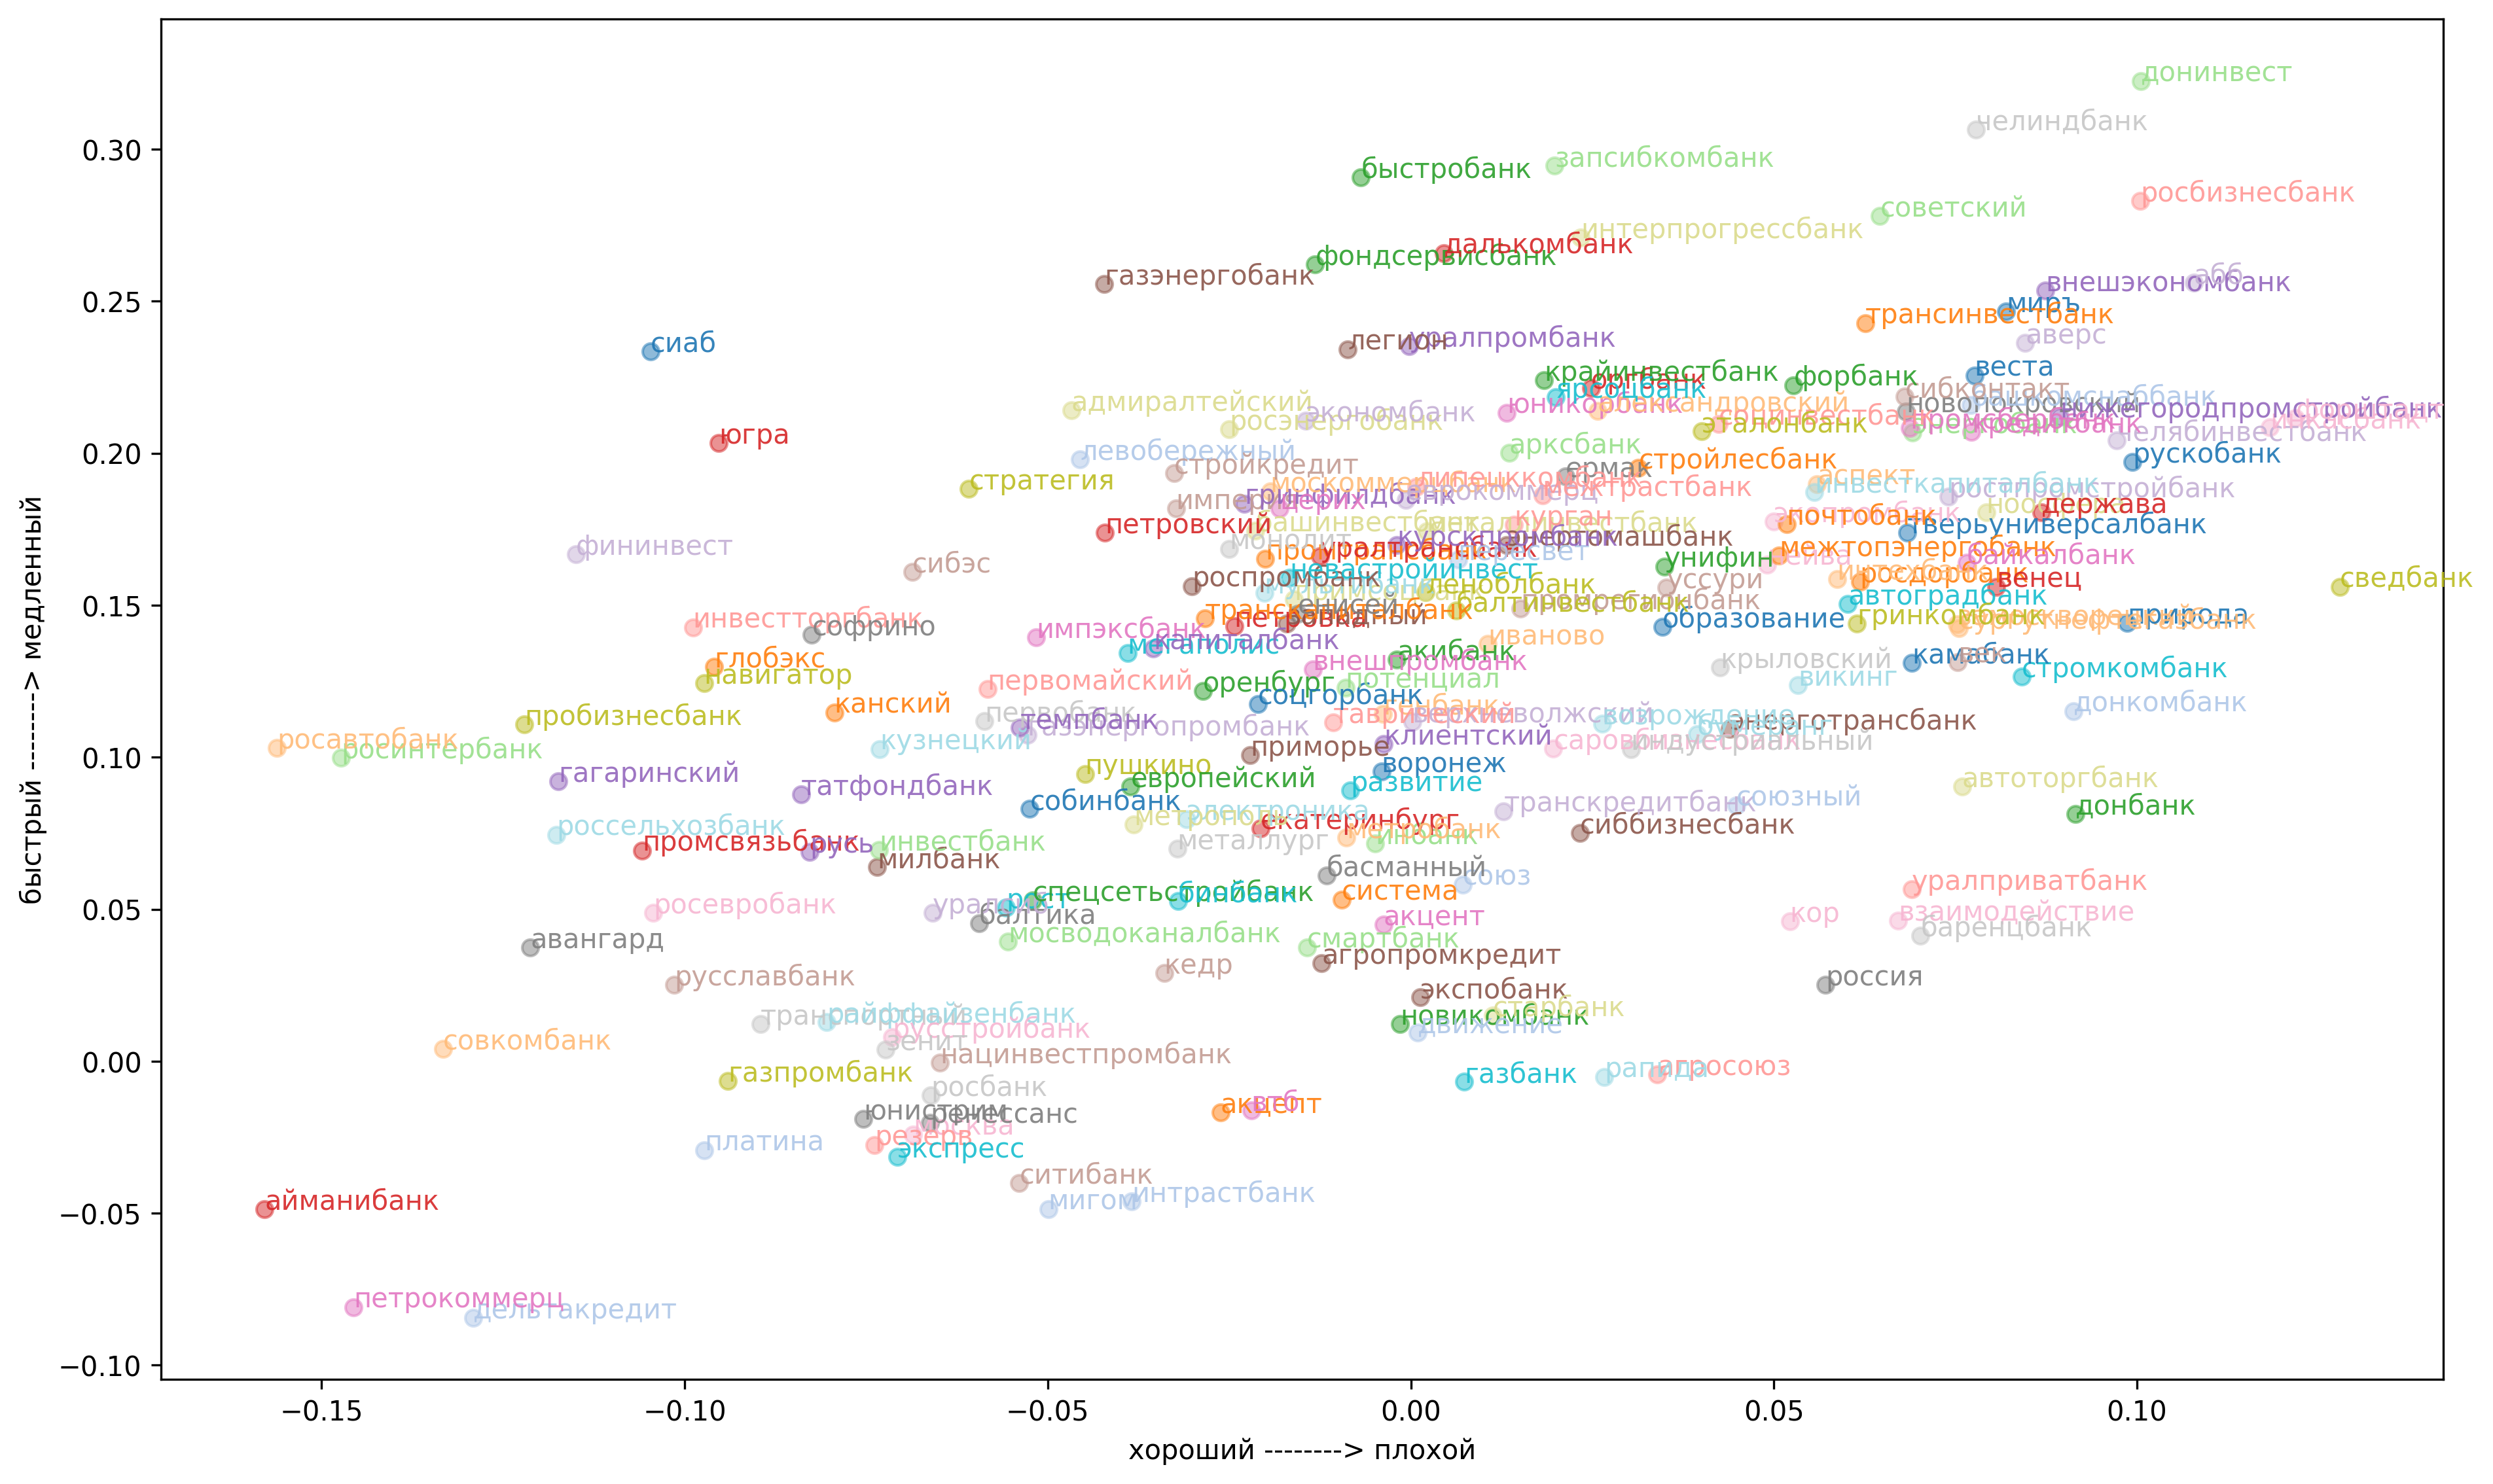

In [ ]:
word2viz_plot(df, banks, "плохой - хороший", "медленный - быстрый", labels=banks)

**Задание 2: распространить метку.**

1. Определите 5–8 позитивных слов (например, быстрый, удобный) и 5–8 негативных слов (например, очередь, медленно). Эти слова будут основной будущего оценочного словаря;

2. Пусть позитивному классу соответствует метка 1, негативному — -1;

3. Пометьте выбранные слова в лексическом графе соответствующими метками;

4. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе;

5. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 — это и есть искомые оценочные слова.

In [ ]:
# Позитивно и негативно окрашенные слова:
words_positive = ['быстрый', 'удобный', 'хороший', 'благодарность', 'полезный', 'качественный']
words_negaitive = ['очередь', 'медленный', 'плохой', 'жалоба', 'бесполезный', 'ужасный']

Для распространения метки воспользуемся LabelPropagation библиотеки sklearn.

In [ ]:
# Добавление столбца со значениями меток в датасет с эмбеддингами:
df.insert(0, 'labels', np.nan)

In [ ]:
df.head()

,labels,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
банк,NaN,-0.003030,0.007679,-0.033795,-0.016396,-0.106224,0.030192,-0.039812,-0.054128,-0.148033,...,0.042592,0.003572,0.027743,0.033250,-0.058803,0.053105,-0.006374,-0.061168,0.021992,-0.184857
карта,NaN,-0.012680,0.080544,-0.032297,-0.045083,0.105034,0.096878,-0.018433,0.003406,0.052482,...,0.082771,0.057119,-0.033406,0.161868,0.005732,-0.041860,0.010158,-0.000627,-0.025517,0.040845
это,NaN,0.004671,-0.011008,-0.071990,-0.022933,0.091862,0.035419,0.007382,-0.067259,-0.013740,...,0.036694,0.007750,0.040283,0.036750,0.054314,0.061089,-0.030200,0.060635,0.044083,-0.144211
всё,NaN,-0.024983,-0.001947,-0.024543,0.047580,0.098818,-0.056608,0.011716,0.021782,0.010400,...,0.087870,-0.059957,-0.050311,0.034196,-0.018948,0.006575,-0.149974,-0.003860,-0.006865,-0.069896
деньга,NaN,0.060136,-0.020317,0.086868,0.002256,0.051925,0.105414,0.020903,0.006861,0.056692,...,-0.004852,0.067368,-0.010058,0.099513,-0.023938,-0.067010,-0.069422,0.011901,-0.101768,0.063219


Согласно документации по LabelPropagation, немаркированные элементы должны быть помечены тэгом -1, поэтому определенные выше слова позитивного и негативного классов пометим цифрами 1 и 0 соответственно.

In [ ]:
df.loc[words_positive, 'labels'] = 1
df.loc[words_negaitive, 'labels'] = 0

In [ ]:
df.loc[words_positive]

,labels,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
быстрый,1.0,-0.105852,-0.076065,0.077719,-0.015017,0.038022,0.010844,-0.077365,0.018841,0.010600,...,-0.027872,-0.076505,-0.046866,-0.012531,-0.032298,0.057710,0.050355,-0.071737,-0.019650,-0.206797
удобный,1.0,-0.076198,-0.102863,0.099148,-0.035208,0.030364,0.083686,-0.054446,-0.020387,-0.005482,...,0.043535,-0.065979,0.003451,0.035371,-0.029592,0.086175,-0.060503,0.069620,-0.077997,-0.117377
хороший,1.0,-0.050216,0.090736,0.066592,-0.055813,-0.023803,-0.087732,-0.007546,-0.028851,-0.024603,...,0.035189,-0.028121,-0.041484,-0.002846,0.030521,0.136985,-0.050046,-0.024254,0.037944,-0.058536
благодарность,1.0,0.004118,0.003323,-0.007291,0.089007,0.048063,-0.008069,0.089152,0.080146,-0.025121,...,-0.006072,-0.084450,-0.093876,-0.010561,-0.035286,0.047441,0.100493,-0.061278,0.099942,-0.025969
полезный,1.0,0.004412,-0.026721,0.114267,-0.048224,-0.061199,-0.015561,-0.050771,-0.012136,0.032426,...,-0.008600,-0.006407,0.083181,-0.021322,0.108310,0.064308,-0.047206,0.021898,0.025642,-0.064431
качественный,1.0,-0.092052,-0.068594,0.076003,0.132345,-0.029592,0.002918,-0.027015,0.006153,0.036951,...,0.001554,-0.060157,0.006119,-0.020195,0.048710,0.147977,0.069727,0.000459,0.147205,-0.078081


In [ ]:
df.loc[words_negaitive]

,labels,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
очередь,0.0,0.036306,-0.012117,0.032777,-0.003893,0.063708,-0.016563,-0.088220,0.043265,0.067350,...,0.055582,0.045381,0.045930,-0.009359,-0.043674,0.040424,0.026510,-0.027621,-0.059651,0.003145
медленный,0.0,0.003284,-0.007376,0.056907,0.010632,-0.051630,0.021295,-0.091271,-0.084066,0.048008,...,-0.006968,-0.030365,0.073004,-0.057437,0.062117,0.124564,0.033563,0.005716,0.102585,-0.078862
плохой,0.0,-0.019861,0.042172,-0.021419,-0.008144,-0.095443,-0.083965,-0.041533,0.010748,0.005441,...,0.051470,-0.100616,-0.032240,-0.018870,-0.028159,0.134503,0.031969,0.022024,0.080527,-0.012501
жалоба,0.0,0.090869,0.000920,0.029980,0.069979,-0.011694,0.006348,0.059479,-0.015861,-0.001588,...,-0.078393,0.001635,-0.006189,0.100484,-0.024028,-0.102740,0.046117,0.004682,0.029312,0.016220
бесполезный,0.0,0.015435,-0.038456,0.006465,0.007357,-0.118619,0.078828,-0.027339,0.044598,0.032150,...,0.119399,-0.034764,0.131100,-0.019934,-0.038877,-0.004890,0.008166,-0.004032,-0.057064,0.026843
ужасный,0.0,0.078962,0.028358,0.013431,-0.079124,-0.092919,-0.066052,-0.140768,-0.052025,0.048263,...,0.008968,-0.078750,0.036345,-0.035826,0.015499,0.091129,0.105506,-0.008145,0.065175,0.046556


In [ ]:
# Остальные значения (Nan) столбца labels заменим на -1:
df['labels'] = df['labels'].fillna(-1)

In [ ]:
df.labels.unique()

array([-1.,  0.,  1.])

In [ ]:
# Сбросим индексы датафрейма:
df_for_lp = df.reset_index()

In [ ]:
# Переименуем столбец со словами (значения которого до последней операции служили индексами):
df_for_lp.rename(columns={0:'word'}, inplace=True)
df_for_lp[:3]

,word,labels,1,2,3,4,5,6,7,8,...,291,292,293,294,295,296,297,298,299,300
0,банк,-1.0,-0.003030,0.007679,-0.033795,-0.016396,-0.106224,0.030192,-0.039812,-0.054128,...,0.042592,0.003572,0.027743,0.033250,-0.058803,0.053105,-0.006374,-0.061168,0.021992,-0.184857
1,карта,-1.0,-0.012680,0.080544,-0.032297,-0.045083,0.105034,0.096878,-0.018433,0.003406,...,0.082771,0.057119,-0.033406,0.161868,0.005732,-0.041860,0.010158,-0.000627,-0.025517,0.040845
2,это,-1.0,0.004671,-0.011008,-0.071990,-0.022933,0.091862,0.035419,0.007382,-0.067259,...,0.036694,0.007750,0.040283,0.036750,0.054314,0.061089,-0.030200,0.060635,0.044083,-0.144211


In [ ]:
# Датасет с фичами и серия с целевой переменной:
X, y = df_for_lp.drop(columns=['labels', 'word'], axis=1), df_for_lp.labels

In [ ]:
# Создание модели классификатора:
from sklearn.semi_supervised import LabelPropagation
label_prop_model = LabelPropagation(kernel='knn')

In [ ]:
# Обучение:
%%time
label_prop_model.fit(X, y)

CPU times: user 2min 39s, sys: 228 ms, total: 2min 39s
Wall time: 1min 46s


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(


LabelPropagation(kernel='knn')

In [ ]:
# Предсказание классов:
pred = label_prop_model.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


In [ ]:
pred_s = pd.Series(pred)
pred_s

0        0.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
63409    0.0
63410    0.0
63411    0.0
63412    0.0
63413    0.0
Length: 63414, dtype: float64

In [ ]:
pred_s.unique()

array([0., 1.])

В результате работы модели каждое слово отнесено к одному из 2-х классов, слов без маркировки не осталось.

In [ ]:
# Датафрейм с результатами

df_res = pd.concat([df_for_lp.word, y, pred_s], axis=1)
df_res.rename(columns={0:'prediction'}, inplace=True)

In [ ]:
# Первые 10 значений датафрейма с результатами:
df_res[:100]

,word,labels,prediction
0,банк,-1.0,0.0
1,карта,-1.0,1.0
2,это,-1.0,0.0
3,всё,-1.0,0.0
4,деньга,-1.0,0.0
...,...,...,...
95,стать,-1.0,0.0
96,нужно,-1.0,0.0
97,несколько,-1.0,1.0
98,тк,-1.0,0.0


Из первых 100 слов словам "карта", "первый", "несколько" (которых не было в списках положительных и отрицательны) присвоен тэг 1.0 (позитивный класс), остальным 0.0 (негативный класс).

In [ ]:
# Потестируем на отдельных словах:
df_res.loc[df_res['word'].isin(['хороший', 'плохой', 'уточнить', 'радовать', 'злой', 'благодарить'])]

,word,labels,prediction
135,хороший,1.0,1.0
235,уточнить,-1.0,0.0
612,плохой,0.0,0.0
1493,радовать,-1.0,0.0
1602,благодарить,-1.0,0.0
3619,злой,-1.0,0.0


Слова "благодарить", "радовать" отнесены к негативному классу, хотя негативного смысла не несут.

В целом, качество классификации получилось невысоким.